In [16]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import torchvision
from torchvision import *
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
import time
import copy
import os

import pdb

images-size: torch.Size([32, 3, 256, 256])
out-size: torch.Size([3, 1034, 2066])


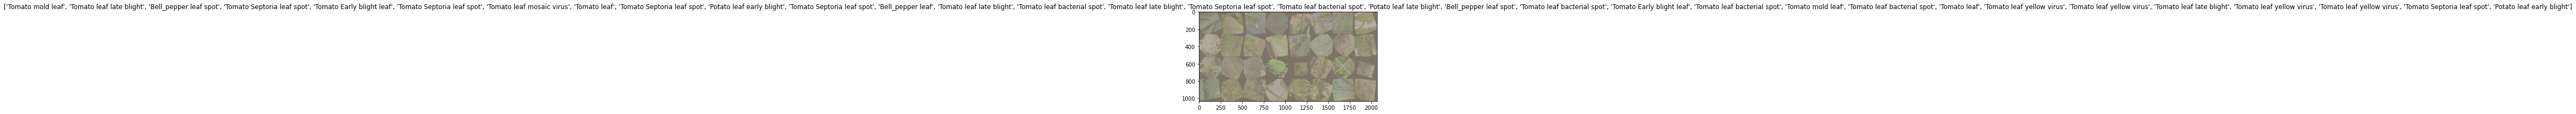

In [40]:
batch_size = 32
learning_rate = 1e-3

transform = transforms.Compose(
[
    transforms.CenterCrop(256),
    transforms.RandomAffine(degrees=90,translate=(0.1,0.1)),
    transforms.ToTensor()
])

train_dataset = datasets.ImageFolder(root='PlantVillage_Training_Set', transform=transform)
#test_dataset = datasets.ImageFolder(root='test', transform=transform)
test_dataset = datasets.ImageFolder(root='use_test_plantvillage_model', transform=transform)
#test_dataset = datasets.ImageFolder(root='PlantVillage_Testing_Set', transform=transform)
valid_dataset = datasets.ImageFolder(root='PlantVillage_Validation_Set', transform=transform)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
validation_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

def imshow(inp, title=None):
    
    inp = inp.cpu() if device else inp
    inp = inp.numpy().transpose((1, 2, 0))
    
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)
    
images, labels = next(iter(test_dataloader)) 
print("images-size:", images.shape)

out = torchvision.utils.make_grid(images)
print("out-size:", out.shape)

imshow(out, title=[test_dataset.classes[x] for x in labels])

In [18]:
net = models.resnet18(pretrained=False)
net = net.cuda() if device else net
net

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [27]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.0001, momentum=0.9)

def accuracy(out, labels):
    _,pred = torch.max(out, dim=1)
    return torch.sum(pred==labels).item()

num_ftrs = net.fc.in_features
net.fc = nn.Linear(num_ftrs, 15)
net.fc = net.fc.cuda() if device else net.fc

In [28]:
device
net.fc

Linear(in_features=512, out_features=15, bias=True)

In [29]:
n_epochs = 15
print_every = 10
valid_loss_min = np.Inf
val_loss = []
val_acc = []
train_loss = []
train_acc = []
total_step = len(train_dataloader)
for epoch in range(1, n_epochs+1):
    running_loss = 0.0
    correct = 0
    total=0
    print(f'Epoch {epoch}\n')
    for batch_idx, (data_, target_) in enumerate(train_dataloader):
        data_, target_ = data_.to(device), target_.to(device)
        optimizer.zero_grad()
        
        outputs = net(data_)
        loss = criterion(outputs, target_)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _,pred = torch.max(outputs, dim=1)
        correct += torch.sum(pred==target_).item()
        total += target_.size(0)
        if (batch_idx) % 20 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch, n_epochs, batch_idx, total_step, loss.item()))
    train_acc.append(100 * correct / total)
    train_loss.append(running_loss/total_step)
    print(f'\ntrain-loss: {np.mean(train_loss):.4f}, train-acc: {(100 * correct/total):.4f}')
    batch_loss = 0
    total_t=0
    correct_t=0
    with torch.no_grad():
        net.eval()
        for data_t, target_t in (validation_dataloader):
            data_t, target_t = data_t.to(device), target_t.to(device)
            outputs_t = net(data_t)
            loss_t = criterion(outputs_t, target_t)
            batch_loss += loss_t.item()
            _,pred_t = torch.max(outputs_t, dim=1)
            correct_t += torch.sum(pred_t==target_t).item()
            total_t += target_t.size(0)
        val_acc.append(100 * correct_t/total_t)
        val_loss.append(batch_loss/len(validation_dataloader))
        network_learned = batch_loss < valid_loss_min
        print(f'validation loss: {np.mean(val_loss):.4f}, validation acc: {(100 * correct_t/total_t):.4f}\n')

        
        if network_learned:
            valid_loss_min = batch_loss
            torch.save(net.state_dict(), 'resnet.pt')
            print('Improvement-Detected, save-model')
    net.train()

Epoch 1

Epoch [1/15], Step [0/439], Loss: 3.1189
Epoch [1/15], Step [20/439], Loss: 2.7712
Epoch [1/15], Step [40/439], Loss: 2.5180
Epoch [1/15], Step [60/439], Loss: 2.4395
Epoch [1/15], Step [80/439], Loss: 2.2457
Epoch [1/15], Step [100/439], Loss: 2.1547
Epoch [1/15], Step [120/439], Loss: 2.3003
Epoch [1/15], Step [140/439], Loss: 1.7964
Epoch [1/15], Step [160/439], Loss: 2.0603
Epoch [1/15], Step [180/439], Loss: 2.1388
Epoch [1/15], Step [200/439], Loss: 2.1254
Epoch [1/15], Step [220/439], Loss: 1.6647
Epoch [1/15], Step [240/439], Loss: 1.7216
Epoch [1/15], Step [260/439], Loss: 1.7797
Epoch [1/15], Step [280/439], Loss: 1.3395
Epoch [1/15], Step [300/439], Loss: 1.5832
Epoch [1/15], Step [320/439], Loss: 1.5716
Epoch [1/15], Step [340/439], Loss: 1.5046
Epoch [1/15], Step [360/439], Loss: 1.1723
Epoch [1/15], Step [380/439], Loss: 1.7410
Epoch [1/15], Step [400/439], Loss: 1.4524
Epoch [1/15], Step [420/439], Loss: 1.6578

train-loss: 1.9110, train-acc: 38.9222
validation 

Epoch [8/15], Step [340/439], Loss: 0.6941
Epoch [8/15], Step [360/439], Loss: 0.8588
Epoch [8/15], Step [380/439], Loss: 0.6973
Epoch [8/15], Step [400/439], Loss: 1.0370
Epoch [8/15], Step [420/439], Loss: 0.7697

train-loss: 1.2716, train-acc: 75.6273
validation loss: 1.0174, validation acc: 78.2973

Improvement-Detected, save-model
Epoch 9

Epoch [9/15], Step [0/439], Loss: 0.7050
Epoch [9/15], Step [20/439], Loss: 1.1389
Epoch [9/15], Step [40/439], Loss: 0.6786
Epoch [9/15], Step [60/439], Loss: 0.9249
Epoch [9/15], Step [80/439], Loss: 0.5691
Epoch [9/15], Step [100/439], Loss: 0.5797
Epoch [9/15], Step [120/439], Loss: 0.9370
Epoch [9/15], Step [140/439], Loss: 1.0141
Epoch [9/15], Step [160/439], Loss: 0.6921
Epoch [9/15], Step [180/439], Loss: 1.0695
Epoch [9/15], Step [200/439], Loss: 0.7723
Epoch [9/15], Step [220/439], Loss: 0.8202
Epoch [9/15], Step [240/439], Loss: 0.9267
Epoch [9/15], Step [260/439], Loss: 0.7417
Epoch [9/15], Step [280/439], Loss: 0.6327
Epoch [9/15], 

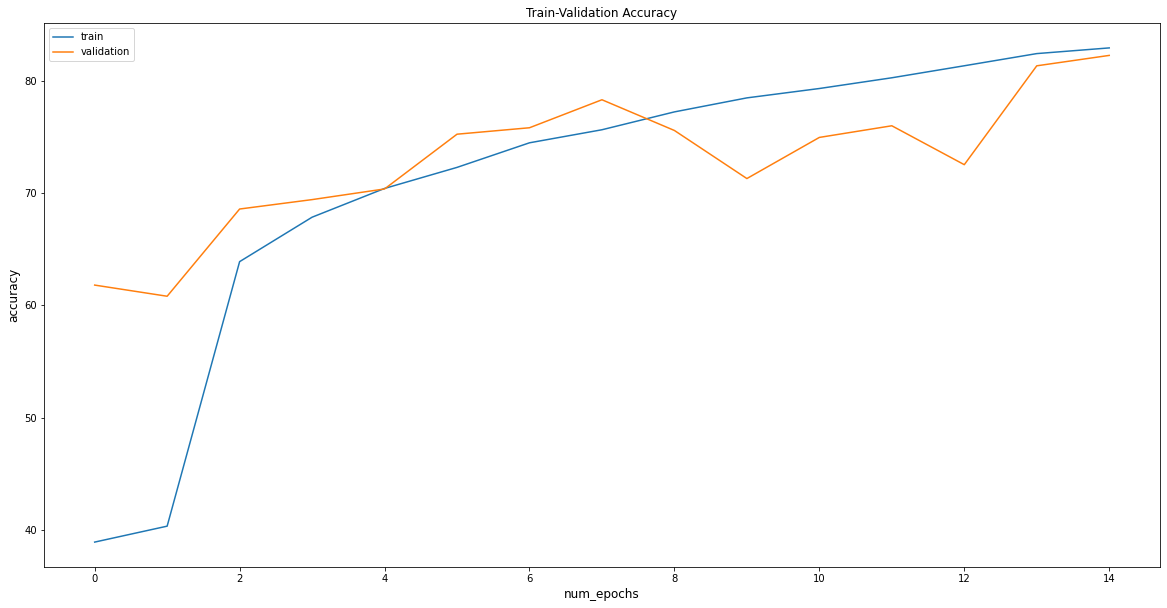

In [30]:
fig = plt.figure(figsize=(20,10))
plt.title("Train-Validation Accuracy")
plt.plot(train_acc, label='train')
plt.plot(val_acc, label='validation')
plt.xlabel('num_epochs', fontsize=12)
plt.ylabel('accuracy', fontsize=12)
plt.legend(loc='best')

In [3]:
# Run if trained model available
net = models.resnet18(pretrained=False)
net = net.cuda() if device else net

num_ftrs = net.fc.in_features
net.fc = nn.Linear(num_ftrs, 15)
net.fc = net.fc.cuda() if device else net.fc

net.load_state_dict(torch.load('resnet.pt'))

<All keys matched successfully>

In [ ]:
from bs4 import BeautifulSoup
classes = set()
for i in range(2330):
    file = 'testing_leaf_type/annotations/plantdoc' + str(i) + '.xml'
    with open(file) as f:
        data = f.read()
        xml_data = BeautifulSoup(data, 'xml')
        objects = xml_data.find_all('name')
        for obj in objects:
            classes.add(obj)

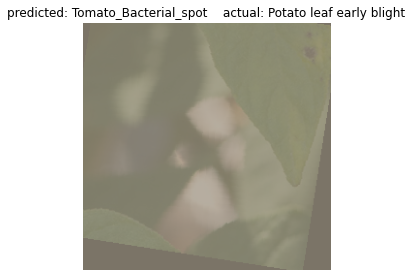

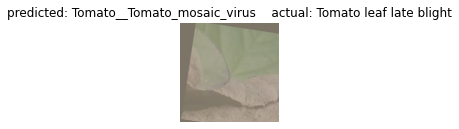

In [73]:
def visualize_model(net, num_images=2):
    images_so_far = 0
    fig = plt.figure(figsize=(15, 10))
    
    for i, data in enumerate(test_dataloader):
        inputs, labels = data
        if device:
            inputs, labels = inputs.cuda(), labels.cuda()
        outputs = net(inputs)
        _, preds = torch.max(outputs.data, 1)
        preds = preds.cpu().numpy() if device else preds.numpy()
        #pdb.set_trace()
        for j in range(inputs.size()[0]):
            images_so_far += 1
            ax = plt.subplot(2, num_images//2, images_so_far)
            ax.axis('off')
            #pdb.set_trace()
            ax.set_title('predicted: {}'.format(train_dataset.classes[preds[j]]) + '    actual: {}'.format(test_dataset.classes[labels[j]]))
            imshow(inputs[j])
            
            if images_so_far == num_images:
                return 
            
plt.ion()
visualize_model(net)
plt.ioff()

In [64]:
(test_dataset.classes)

['Bell_pepper leaf',
 'Bell_pepper leaf spot',
 'Potato leaf early blight',
 'Potato leaf late blight',
 'Tomato Early blight leaf',
 'Tomato Septoria leaf spot',
 'Tomato leaf',
 'Tomato leaf bacterial spot',
 'Tomato leaf late blight',
 'Tomato leaf mosaic virus',
 'Tomato leaf yellow virus',
 'Tomato mold leaf',
 'Tomato two spotted spider mites leaf']

In [47]:
train_dataset.classes

['Pepper__bell___Bacterial_spot',
 'Pepper__bell___healthy',
 'Potato___Early_blight',
 'Potato___Late_blight',
 'Potato___healthy',
 'Tomato_Bacterial_spot',
 'Tomato_Early_blight',
 'Tomato_Late_blight',
 'Tomato_Leaf_Mold',
 'Tomato_Septoria_leaf_spot',
 'Tomato_Spider_mites_Two_spotted_spider_mite',
 'Tomato__Target_Spot',
 'Tomato__Tomato_YellowLeaf__Curl_Virus',
 'Tomato__Tomato_mosaic_virus',
 'Tomato_healthy']